In [1]:
import load_data
import numpy as np
from sklearn.decomposition import PCA

def pca(X_train, X_test,n_comp):
    pca = PCA(n_components=n_comp, svd_solver='full')
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    return X_train, X_test


In [2]:
# load data
training_data = load_data.read_data("train.csv")
testing_data = load_data.read_data("test.csv")
testing_labels = load_data.read_data("submission.csv")
X_train, X_test = load_data.vectorize_data(training_data, testing_data)

Y_train = np.array(training_data)[:, -1]
Y_test = np.array(testing_labels)[:, -1]

print(X_train.shape)
print(X_test.shape)

X_train = X_train.toarray()
X_test = X_test.toarray()


(7613, 19262)
(3263, 19262)


In [3]:
# reduce data
# X_train, X_test = pca(X_train, X_test, 0.8)

# np.save('X_train_PCA.npy',X_train)
# np.save('X_test_PCA.npy',X_test)

X_train=np.load('X_train_PCA.npy')
X_test=np.load('X_test_PCA.npy')

print(X_train.shape)
print(X_test.shape)

(7613, 2952)
(3263, 2952)


In [4]:
def mpp(Tr, yTr, Te, cases, P):
    # training process - derive the model
    covs, means = {}, {}     # dictionaries
    covsum = None

    classes = np.unique(yTr)   # get unique labels as dictionary items
    classn = len(classes)    # number of classes
    classes = classes.astype(int)
    
    for c in classes:
        # filter out samples for the c^th class
        arr = Tr[yTr == c]  
        # calculate statistics
        covs[c] = np.cov(np.transpose(arr))
        means[c] = np.mean(arr, axis=0)  # mean along the columns
        # accumulate the covariance matrices for Case 1 and Case 2
        if covsum is None:
            covsum = covs[c]
        else:
            covsum += covs[c]
    
    # used by case 2
    covavg = covsum / classn
    
    # used by case 1
    if cases == 1:
#         varavg = np.sum(np.diagonal(covavg)) / classn
        varavg = np.sum(covavg) / classn
        
    # testing process - apply the learned model on test set 
    disc = np.zeros(classn)
    
    if Te.ndim == 1:
        nr = 1
    else:
        nr = Te.shape[0]
    y = np.zeros(nr)            # to hold labels assigned from the learned model
    for i in range(nr):
        for c in classes:
            if Te.ndim == 1:
                Test = Te
            else:
                Test = Te[i]
                
            if cases == 1:
                edist2 = util.euc2(means[c], Test)
                disc[c] = -edist2 / (2 * varavg) + np.log(P[c] + 0.000001)
            elif cases == 2: 
                mdist2 = util.mah2(means[c], Test, covavg)
                disc[c] = -mdist2 / 2 + np.log(P[c] + 0.000001)
            elif cases == 3:
                if Tr.ndim != 1 and Tr.shape[1] != 1:
                    mdist2 = util.mah2(means[c], Test, covs[c])
                    disc[c] = -mdist2 / 2 - np.log(np.linalg.det(covs[c])) / 2 + np.log(P[c] + 0.000001)
                else:
                    mdist2 = np.dot(np.dot(means[c]-Test, 1.0/covs[c]), means[c]-Test)
                    disc[c] = -mdist2 / 2 - np.log(covs[c]) / 2 + np.log(P[c] + 0.000001)
            else:
                print("Can only handle case numbers 1, 2, 3.")
                sys.exit(1)
        y[i] = disc.argmax()
            
    return y  


<ipython-input-4-3dbad684d5a2>:54: RuntimeWarning: divide by zero encountered in log
  disc[c] = -mdist2 / 2 - np.log(np.linalg.det(covs[c])) / 2 + np.log(P[c] + 0.000001)


[0. 0. 0. ... 0. 0. 0.]
Precision: 0.0 / Recall: 0.0 / F1-Score: 0.0 / Accuracy: 0.57


C:\Users\Zmiao\anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


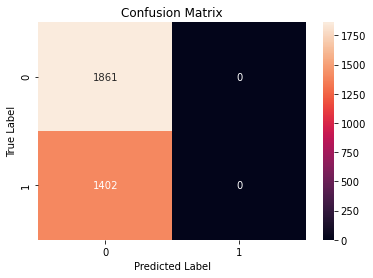

The learning process takes 16225.746041059494 seconds.


In [5]:
import util
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
import pandas as pd

Y_train = Y_train.astype(int)
Y_test= Y_test.astype(int)

# the training and testing datasets should have the same dimension
_, nftrain = X_train.shape
_, nftest = X_test.shape
assert nftrain == nftest   
    
#     # ask the user to input which discriminant function to use
#     prompt = '''
#     Type of discriminant functions supported assuming Gaussian pdf:
#     1 - minimum Euclidean distance classifier
#     2 - minimum Mahalanobis distance classifier
#     3 - quadratic classifier
#     '''
#     print(prompt)
#     str = input('Please input 1, 2, or 3: ')
#     cases = int(str)

#     # ask the user to input prior probability that needs to sum to 1
#     prop_str = input("Please input prior probabilities in float numbers, separated by space, and they must add to 1: \n")
#     numbers = prop_str.split()
#     P = np.zeros(len(numbers))
#     Psum = 0
#     for i in range(len(numbers)):
#         P[i] = float(numbers[i])
#         Psum += P[i]
#     if Psum != 1:
#         print("Prior probabilities do not add up to 1. Please check!")
#         sys.exit(1)

    # derive the decision rule from the training set and apply on the test set
t0 = time.time()           # start time
Y_pred = mpp(X_train, Y_train, X_test, 3, np.array([0.5, 0.5]))
t1 = time.time()           # ending time

print(Y_pred)
Y_pred = Y_pred.astype("int")
Y_pred = Y_pred.astype("str")
# calculate accuracy
Y_train = Y_train.astype("str")
Y_test= Y_test.astype("str")
precision, recall, fscore, train_support = score(Y_test, Y_pred, pos_label="1", average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
        round(precision, 3), round(recall, 3), round(fscore, 3), round(acs(Y_test, Y_pred), 3)))

cm = confusion_matrix(Y_test, Y_pred)
class_label = ["0", "1"]
df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


print(f'The learning process takes {t1 - t0} seconds.')


In [18]:
#---------------------------knn---------------------------------
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
import pandas as pd

def knn(X_train, Y_train, X_test, Y_test, params):

    start = time.time()

    mlp = KNeighborsClassifier(n_neighbors=params['n_neighbors'])
    mlp.fit(X_train, Y_train)
    Y_pred = mlp.predict(X_test)

    end = time.time()

    precision, recall, fscore, train_support = score(Y_test, Y_pred, pos_label='1', average='binary')
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
        round(precision, 3), round(recall, 3), round(fscore, 3), round(acs(Y_test, Y_pred), 3)))

    print("Execution Time: " + str(end - start))

    cm = confusion_matrix(Y_test, Y_pred)
    class_label = ["0", "1"]
    df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return round(acs(Y_test, Y_pred), 3)

def grid_search_knn(X_train, Y_train):
    #grid searching
    neighbors = list(range(1,50,2))

    param_grid = {
        'n_neighbors' : neighbors
    }

    clf = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, n_jobs = -1)
    grid_search.fit(X_train, Y_train)
    #print(grid_search.cv_results_)
    print(grid_search.best_params_)
    return grid_search.best_params_

n_neighbors= grid_search_knn(X_train, Y_train)

Precision: 0.825 / Recall: 0.591 / F1-Score: 0.688 / Accuracy: 0.77
Execution Time: 174.3864986896515


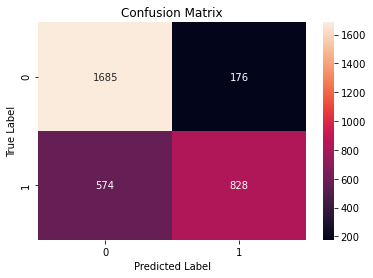

In [43]:
#---------------------------knn---------------------------------
params = {
        'n_neighbors': 11
}

accu_knn = knn(X_train, Y_train, X_test, Y_test, params)

Precision: 0.366 / Recall: 0.056 / F1-Score: 0.097 / Accuracy: 0.553
Execution Time: 2.7261710166931152


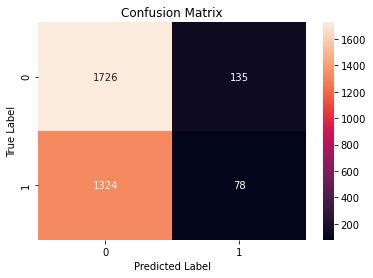

In [39]:
#---------------------------kmeans---------------------------------
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

def grid_search_kmeans(X_train, Y_train):
    #grid searching
    param_grid = {
        'n_clusters' : [2],
        'init' : ['k-means++'],
        'n_init': list(range(1,30,10)),
        'max_iter' : [10000]
    }

    clf = KMeans()
    grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, n_jobs = 6)
    grid_search.fit(X_train, Y_train)
    #print(grid_search.cv_results_)
    print(grid_search.best_params_)
    return grid_search.best_params_


def kmeans(X_train, Y_train, X_test, Y_test, params):
    start = time.time()

    mlp = KMeans(n_clusters=params['n_clusters'], max_iter=100000)
    mlp.fit(X_train)
    Y_pred = mlp.predict(X_test)

    end = time.time()

    # typecast to string to match X_test format
    Y_pred = [str(x) for x in Y_pred]

    precision, recall, fscore, train_support = score(Y_test, Y_pred, pos_label='1', average='binary')
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
        round(precision, 3), round(recall, 3), round(fscore, 3), round(acs(Y_test, Y_pred), 3)))

    print("Execution Time: " + str(end - start))

    cm = confusion_matrix(Y_test, Y_pred)
    class_label = ["0", "1"]
    df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return round(acs(Y_test, Y_pred), 3)

#n_clusters = grid_search_kmeans(X_train, Y_train)
params = {
        'n_clusters': 2
}

accu_kmeans= kmeans(X_train, Y_train, X_test, Y_test, params)

C:\Users\Zmiao\anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0 / Recall: 0.0 / F1-Score: 0.0 / Accuracy: 0.57
Execution Time: 5.5031843185424805


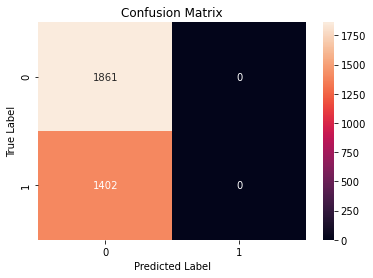

In [41]:
#----------------------------wta--------------------------------
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time


def wta(X_train, Y_train, X_test, Y_test, params):
    start = time.time()

    mlp = MiniBatchKMeans(n_clusters=params['n_clusters'], max_iter=100000, batch_size=1)
    mlp.fit(X_train)
    Y_pred = mlp.predict(X_test)

    end = time.time()

    # typecast to string to match X_test format
    Y_pred = [str(x) for x in Y_pred]

    precision, recall, fscore, train_support = score(Y_test, Y_pred, pos_label='1', average='binary')
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
        round(precision, 3), round(recall, 3), round(fscore, 3), round(acs(Y_test, Y_pred), 3)))

    print("Execution Time: " + str(end - start))

    cm = confusion_matrix(Y_test, Y_pred)
    class_label = ["0", "1"]
    df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return round(acs(Y_test, Y_pred), 3)

params = {
        'n_clusters': 2
}

accu_kmeans= wta(X_train, Y_train, X_test, Y_test, params)

Precision: 0.856 / Recall: 0.505 / F1-Score: 0.635 / Accuracy: 0.751
Execution time: 21.41426396369934 seconds.


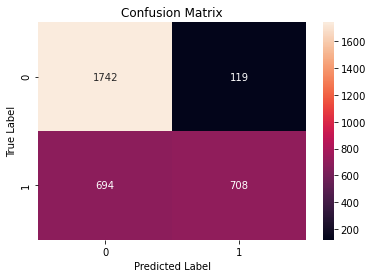

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

def rf(X_train, Y_train, X_test, Y_test):

    start = time.time()

    rf = RandomForestClassifier(max_depth=None, n_jobs=-1)
    rf.fit(X_train, Y_train)
    Y_pred = rf.predict(X_test)

    end = time.time()

    precision, recall, fscore, train_support = score(Y_test, Y_pred, pos_label='1', average='binary')
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
        round(precision, 3), round(recall, 3), round(fscore, 3), round(acs(Y_test, Y_pred), 3)))
    print("Execution time: " + str(end - start) + " seconds.")

    cm = confusion_matrix(Y_test, Y_pred)
    class_label = ["0", "1"]
    df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return round(acs(Y_test, Y_pred), 3)

accu_rf = rf(X_train, Y_train, X_test, Y_test)


Precision: 0.824 / Recall: 0.695 / F1-Score: 0.754 / Accuracy: 0.805
Execution Time: 326.7871742248535


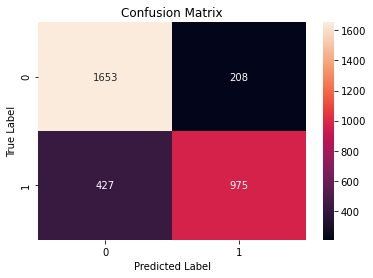

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time


def svm(X_train, Y_train, X_test, Y_test):
    start = time.time()

    svclassifier = SVC()
    svclassifier.fit(X_train, Y_train)
    Y_pred = svclassifier.predict(X_test)

    end = time.time()

    precision, recall, fscore, train_support = score(Y_test, Y_pred, pos_label='1', average='binary')
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
        round(precision, 3), round(recall, 3), round(fscore, 3), round(acs(Y_test, Y_pred), 3)))
    print("Execution Time: " + str(end - start))

    cm = confusion_matrix(Y_test, Y_pred)
    class_label = ["0", "1"]
    df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return round(acs(Y_test, Y_pred), 3)

accu_svm = svm(X_train, Y_train, X_test, Y_test)
